<a href="https://colab.research.google.com/github/import-NeuralNexus-as-NN/cifar-10/blob/main/Cifar_10_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Установка зависимостей

In [ ]:
!pip install keras-tuner silence_tensorflow patool

In [8]:
import numpy as np
import silence_tensorflow.auto
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Dropout
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image

from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from keras.models import load_model

import requests
from urllib.parse import urlencode
import patoolib
import os



In [3]:
#Функция для отображения картинок
def plot_sample(X, y, index):
    plt.figure(figsize = (15,2))
    plt.imshow(X[index])
    plt.xlabel(classes[y[index]])

# Загрузка и нормализация данных

In [9]:
# Загрузка данных
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Названия классов из набора данных CIFAR-10
classes = ['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

y_train = y_train.reshape(-1,)
y_test = y_test.reshape(-1,)

# Нормализация данных
X_train = X_train / 255.0
X_test = X_test / 255.0


170498071/170498071 [==============================] - 5s 0us/step


# Задаём архитектуру нейронной сети, запускаем RandomSearch tuner, который будет искать оптимальные гиперпараметры модели (По факту обучается просто много нейронок с разными параметрами, и в итоге мы получаем самую точную)

In [ ]:
# Создание базовой модели
def create_base_model(hp):
    model = Sequential()

    # Первый сверточный слой
    model.add(Conv2D(filters=hp.Int('conv1_filters', min_value=64, max_value=128, step=32),
                     kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(32, 32, 3)))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Второй сверточный слой
    model.add(Conv2D(filters=hp.Int('conv2_filters', min_value=128, max_value=256, step=64),
                     kernel_size=(3, 3),
                     activation='relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    # Полносвязные слои
    model.add(Dense(units=hp.Int('dense_units', min_value=128, max_value=256, step=64),
                    activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))


  # Компиляция модели
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

# Инициализация RandomSearch tuner
tuner = RandomSearch(
    create_base_model,
    objective='val_accuracy',
    max_trials=24,  # Количество различных комбинаций гиперпараметров, которые будет проверять tuner
    executions_per_trial=1,  # Количество обучений для каждой комбинации гиперпараметров
    directory='tuner_dir',
    project_name='cifar10_tuning'
)

# Подгонка tuner к данным
tuner.search(X_train, y_train, epochs=10, validation_split=0.2)

# Получение оптимальных гиперпараметров
best_hp = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print("Best Hyperparameters:", best_hp)

# Получение оптимальной модели
best_model = tuner.get_best_models(num_models=1)[0]

# Оценка модели на тестовых данных
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)


best_model.save("cifar10_model.h5")
print("Модель сохранена успешно.")

# Качаем все модели из которых ищется лучшая (Если лень ждать обучение)

In [12]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/wYoDsEC4_Lz5Gw'

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

# Загружаем файл и сохраняем его
download_response = requests.get(download_url)
downloaded_file_path = '/content/tuner_dir.rar'

with open(downloaded_file_path, 'wb') as f:
    f.write(download_response.content)

# Разархивируем файл
extracted_path = '/content/'

# Проверяем, существует ли папка для распаковки, и создаем ее при необходимости
if not os.path.exists(extracted_path):
    os.makedirs(extracted_path)

# Распаковываем скачанный архив
patoolib.extract_archive(downloaded_file_path, outdir=extracted_path)

# Удаляем изначальный архив
os.remove(downloaded_file_path)

INFO patool: Extracting /content/tuner_dir.rar ...
INFO:patool:Extracting /content/tuner_dir.rar ...
INFO patool: running /usr/bin/7z x -o/content/ -- /content/tuner_dir.rar
INFO:patool:running /usr/bin/7z x -o/content/ -- /content/tuner_dir.rar
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... /content/tuner_dir.rar extracted to `/content/'.
INFO:patool:... /content/tuner_dir.rar extracted to `/content/'.


# Топ 5 моделей из 24

In [13]:
all_trials = tuner.oracle.get_best_trials(num_trials=64)
sorted_trials = sorted(all_trials, key=lambda x: x.score, reverse=True)

# Вывод топ-5 моделей
for i, trial in enumerate(sorted_trials[:5]):
    print(f"Model {i + 1}: Score - {trial.score}, Hyperparameters - {trial.hyperparameters.values}, ID - {trial.trial_id}")

    top_model = tuner.get_best_models(num_models=5)[i]
    top_model.evaluate(X_test, y_test)


Model 1: Score - 0.7293999791145325, Hyperparameters - {'conv1_filters': 64, 'conv2_filters': 256, 'dense_units': 256}, ID - 13
313/313 [==============================] - 2s 4ms/step - loss: 0.8319 - accuracy: 0.7249
Model 2: Score - 0.7250999808311462, Hyperparameters - {'conv1_filters': 96, 'conv2_filters': 256, 'dense_units': 256}, ID - 16
313/313 [==============================] - 1s 3ms/step - loss: 0.8804 - accuracy: 0.7186
Model 3: Score - 0.7231000065803528, Hyperparameters - {'conv1_filters': 96, 'conv2_filters': 256, 'dense_units': 192}, ID - 23
313/313 [==============================] - 1s 4ms/step - loss: 0.8439 - accuracy: 0.7123
Model 4: Score - 0.7222999930381775, Hyperparameters - {'conv1_filters': 64, 'conv2_filters': 256, 'dense_units': 128}, ID - 19
313/313 [==============================] - 1s 3ms/step - loss: 0.8519 - accuracy: 0.7117
Model 5: Score - 0.7210000157356262, Hyperparameters - {'conv1_filters': 128, 'conv2_filters': 256, 'dense_units': 256}, ID - 05
313

# Проверяем на деле лучшую модель (в Index пишем номер картинки из тестового датасета которую хотим проверить)

In [14]:
#Выбрана модель 4, поскольку она показала самую высокую точност на тестовой выборке
best_model = tuner.get_best_models(num_models=5)[3]

In [15]:
best_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.8519 - accuracy: 0.7117


[0.8518805503845215, 0.7117000222206116]

In [16]:
y_pred = best_model.predict(X_test)

313/313 [==============================] - 1s 3ms/step


In [17]:
y_classes = [np.argmax(element) for element in y_pred]

Обученная модель говорит, что это олень


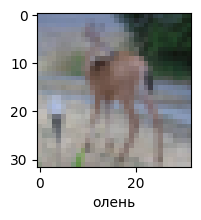

In [19]:
index = 100
plot_sample(X_test, y_test, index)
print('Обученная модель говорит, что это', classes[y_classes[index]])